# QF5204 Project: An Arbitrage-Free Smile Interpolator


## Objectives
- Implement an arbitrage free smile interpolator SmileAF.
- Use the arbitrage free smile interpolator to construct local volatility model.
- Use PDE with local volatility model to price a given set of European options (strike in delta $\times$ maturity).
- Compare the price errors of arbitrage-free smile interpolator and the cubic spline smile interpolator.
- For bonus points, improve the algorithms in terms of precision and efficiency (smile interpolation, implied vol, local vol, PDE, calibration report). One area to consider for improvement is the construction of the tails (wings).

## Smile Arbitrage

1. European call prices are monotonically decreasing with respect to the strike:
    \begin{align}
    C(S_0, K_1, T, \sigma(K_1), r, q) \ge C(S_0, K_2, T, \sigma(K_2), r, q) ~\text{for}~K_1 < K_2
    \end{align}

2. The European call price as a function of strike has to be convex every where: for any three points $K_1 < K_2 < K_3$
    \begin{align}
    \frac{C(K_2) - C(K_1) } {K_2 - K_1} < \frac{C(K_3) - C(K_2) } {K_3 - K_2}
    \end{align}

    or

    \begin{align}
    C(K_2)  < C(K_3)\frac{K_2 - K_1} {K_3 - K_1} + C(K_1)\frac{K_3-K_2} {K_3 - K_1}
    \end{align}

    This is also equivalent to "butterfly price has to be non-negative".

### When Could Smile Arbitrage Happen?

The undiscounted call price is the expectation of payoff under risk neutral measure $Q$.

\begin{align}
C(K) &= \mathbb{E}^{Q}[\max(S-K, 0)] \\
&= \int_{K}^{+\infty} (s-K) p(s) ds 
\end{align}

where $p(s)$ is the probability density function under Q.

The 1st non-arbitrage condition translates to

\begin{align}
& C(K_1) - C(K_2) = \left[ \int_{K_1}^{K_2} (s-K_1) p(s) ds  + \int_{K_2}^{+\infty} (K_2-K_1) p(s) ds \right] \ge 0
\end{align}

The 2nd non-arbitrage condition translates to

\begin{align}
& C(K_3)\frac{K_2 - K_1} {K_3 - K_1} + C(K_1)\frac{K_3-K_2} {K_3 - K_1} - C(K_2) \\
= & \frac{K_3-K_2} {K_3 - K_1} \int_{K_1}^{K_2} (s-K_1) p(s) ds + \frac{K_2 - K_1} {K_3 - K_1} \int_{K_2}^{K_3} (K_3 - s) p(s) ds > 0
\end{align}

So, when could smile arbitrage happen? **When the probability density does not exist**. If we can start with valid probability density function $p(s)$, arbitrage-freeness is guaranteed by construction.

## Arbitrage Free Smile (Based on [Fengler 2009])

- Consider smile construction for a given expiry $T$.
- Compute undiscounted call prices, $\vec{c} = [c_1, c_2, \ldots, c_N]^T$, for $N$ discrete sample strike points, $\vec{k} = [k_1, k_2, \ldots, k_{N}]^T$.
- Compute undiscounted call price $C(K)$ for any $K$ by using cubic spline to interpolate from the sample points $(k_i, c_i)$ (Note: we are using cubic spline to interpolate $(k, c)$ directly instead of using volatility.)
- Consider the second derivative of call price with respect to strike.

    \begin{align}
    \frac{d C}{d K} & =  \frac{d}{dK}\left(\int_K^{\infty} (S - K) p(S) dS\right) = -\int_K^{\infty} p(S) dS \\
    \frac{d^2 C}{d K^2} & = p(K)
    \end{align}

  Let $p_i = p(k_i) = c_i''$ where $p$ is the probability density function.

- Second derivatives in cubic spline interpolation form line segments. Cubic spline on $C(K)$ means linearly interpolate on probability density. If $p_i > 0 \text{  } \forall i$, then $p(k) \ge 0 \text{  }  \forall k$ by construction: **no smile arbitrage**.

- For tails, call prices are almost linear if strike is very far away from spot, we can use **natural cubic spline**: $p_1 = p_N = 0$.
- Our problem is to solve for $[c_1, c_2, \ldots, c_{N}, p_2, \ldots, p_{N-1}]$.

### Problem Statement

Given $M = 5$ input marks: $(\hat k_j, \sigma_j)$ for $j \in [1, 2, \dots, M]$, construct an arbitrage-free smile interpolator (`SmileAF`) as per [Fengler 2009].

- All $M$ input marks need to be matched exactly.
- The call prices need to be as smooth as possible. 
- Assume ATM forward convention: the strike of the middle point of the input marks is the forward; $\sigma_{ATM}$ is implied volatility of the forward.

We cannot directly construct a cubic spline as it would be too coarse and the distribution unrealistic.
So, consider $N = 50$ equally spaced sample points in $[S e^{(r_d - r_f)T -\frac12\sigma_{ATM}^2T - 5 \sigma_{ATM} \sqrt{T}}, S e^{(r_d - r_f)T -\frac12\sigma_{ATM}^2T + 5 \sigma_{ATM} \sqrt{T} }]$, i.e., $\pm 5$ standard deviation based on $\sigma_{ATM}$. Let the length of each segment be $u$. Solve for $c_i$ and $p_i$ with appropriate constraints as described above while optimizing for smoothness on $p$ like in [Fengler 2009]. Use $(c_i, k_i)$ to get the implied volatility $\sigma_i$. Finally, use $(k_i, \sigma_i)$ to construct the Cubic Spline.

**References**

[Fengler 2009] Arbitrage-free smoothing of the implied volatility surface, Quantitative Finance, 2009

### Building Blocks

Below are some building blocks for the project. You contribution should be in SmileAF class.
You can modify any other classes or methods. If you do so, please describe your modification in the project report.

Let's start with the typical smile interpolator using Cubic Spline (taken from assignment 2).

In [1]:
PriceType = float

In [2]:
from scipy.interpolate import CubicSpline


class Smile:
    def __init__(self, k: list[PriceType], sigma: list[float]):
        assert len(k) >= 2, "Need at least 2 points to extrapolate"

        # add an additional point on the right to avoid arbitrage
        _k, _s = (1.1*k[-1] - 0.1*k[-2]), (sigma[-1] + (sigma[-1] - sigma[-2])/10)
        self.k, self.sigma = k + [_k], sigma + [_s]

        # Should we use (k, sigma) or (self.k, sigma)
        self.cubic_spline = CubicSpline(k, sigma, bc_type="clamped")

    def Vol(self, K: PriceType) -> float:
        if K < self.k[0]:
            return self.sigma[0]

        if K > self.k[-1]:
            return self.sigma[-1]

        return self.cubic_spline(K)

Now, perform time interpolation given pillars and the corresponding cubic spline smile.

**MOD 1**: Refactor `ImpliedVol.Vol` and replace magic numbers with named constants

In [3]:
import bisect
import math


class ImpliedVol:
    FINITE_DIFFERENCE_K = 0.001
    FINITE_DIFFERENCE_T = 0.005

    def __init__(self, pillars: list[float], smiles: list[Smile]):
        self.pillars = pillars
        self.smiles = smiles

    def get_smile_index(self, T: float) -> int:
        if T < self.pillars[0]:
            return 0

        if T > self.pillars[-1]:
            return -1

        return bisect.bisect_left(self.pillars, T)

    def Vol(self, T: float, K: PriceType) -> float:
        i_smile = self.get_smile_index(T)
        if i_smile == 0 or i_smile == -1:
            return self.smiles[i_smile].Vol(K)

        nextVol, nextT = self.smiles[i_smile].Vol(K), self.pillars[i_smile]
        nextVar = nextVol * nextVol * nextT

        prevVol, prevT = self.smiles[i_smile - 1].Vol(K), self.pillars[i_smile - 1]
        prevVar = prevVol * prevVol * prevT

        w = (nextT - T) / (nextT - prevT)
        return math.sqrt((w * prevVar + (1 - w) * nextVar) / T)

    def dVoldK(self, T: float, K: PriceType) -> float:
        dk = self.FINITE_DIFFERENCE_K
        return (self.Vol(T, K + dk) - self.Vol(T, K - dk)) / (2 * dk)

    def dVoldT(self, T: float, K: PriceType) -> float:
        dt = self.FINITE_DIFFERENCE_T
        return (self.Vol(T + dt, K) - self.Vol(T, K)) / dt

    def dVol2dK2(self, T: float, K: PriceType) -> float:
        dk = self.FINITE_DIFFERENCE_K
        return (self.Vol(T, K + dk) + self.Vol(T, K - dk) - 2*self.Vol(T, K)) / (dk*dk)

Use this time interpolation to compute local volatility.

**MOD 2:** `s/LV/Vol/`

In [4]:
class LocalVol:
    MIN_VOL = 1e-8
    MAX_VOL = 1

    def __init__(self, iv: ImpliedVol, S0: PriceType, rd: float, rf: float):
        self.iv = iv
        self.S0 = S0
        self.r = rd - rf

    def Vol(self, T: float, S: PriceType) -> float:
        imp = self.iv.Vol(T, S)
        if is_close(T, 0):
            return imp

        sqrt_T = math.sqrt(T)
        sd = imp * sqrt_T
        d1 = (math.log(self.S0 / S) + self.r*T)/sd + sd/2

        dvdk, dvdt, d2vdk2 = self.iv.dVoldK(T, S), self.iv.dVoldT(T, S), self.iv.dVol2dK2(T, S)
        den = (1 + S*d1*sqrt_T*dvdk)**2 + S*S*T*imp*(d2vdk2 - d1*sqrt_T*dvdk*dvdk)
        if den <= 0:
            return math.sqrt(self.MAX_VOL)

        num = imp * (imp + 2*T*(dvdt + self.r*S*dvdk))

        lv = max(self.MIN_VOL, min(num/den, self.MAX_VOL))
        return math.sqrt(lv)

**MOD 3:** `s/PayoffType/OptionType`

In [5]:
from enum import Enum


class OptionType(Enum):
    CALL = 1
    PUT = 2

Copy over second assignment's work to compute smile from marks.

In [6]:
def strikeFromDelta(S: PriceType,
                    r: float,
                    q: float | None,
                    T: float,
                    vol: float,
                    delta: float,
                    option_type: OptionType) -> PriceType:
    assert option_type in [OptionType.CALL, OptionType.PUT]

    delta = abs(delta)

    F = S * math.exp((r - (q or 0)) * T)
    sd = vol * (T ** 0.5)
    d1 = norm.ppf(delta if option_type == OptionType.CALL else 1 - delta)

    return F / math.exp((d1 - sd/2) * sd)


def smileFromMarks(T: float,
                   S: PriceType,
                   r: float,
                   q: float | None,
                   atmvol: float,
                   bf25: float,
                   rr25: float,
                   bf10: float,
                   rr10: float,
                   smileInterpMethod: str = "CUBICSPLINE") -> Smile:

    call_vol10 = atmvol + bf10 + rr10/2
    CK10 = strikeFromDelta(S, r, q, T, call_vol10, 0.1, OptionType.CALL)

    call_vol25 = atmvol + bf25 + rr25/2
    CK25 = strikeFromDelta(S, r, q, T, call_vol25, 0.25, OptionType.CALL)

    put_vol10 = atmvol + bf10 - rr10/2
    PK10 = strikeFromDelta(S, r, q, T, put_vol10, -0.10, OptionType.PUT)

    put_vol25 = atmvol + bf25 - rr25/2
    PK25 = strikeFromDelta(S, r, q, T, put_vol25, -0.25, OptionType.PUT)

    K_atm = F = S * math.exp((r - q) * T)

    strikes = [PK10, PK25, K_atm, CK25, CK10]
    vols = [put_vol10, put_vol25, atmvol, call_vol25, call_vol10]

    if smileInterpMethod == "AF":
        return SmileAF(strikes, vols, T)

    if smileInterpMethod == "CUBICSPLINE":
        return Smile(strikes, vols)

    raise ValueError(f"Unknown smile interpolator method {smileInterpMethod}")

Some basic classes and methods for Options.

**MOD 4:** Remove `assetName` and `expiry` from the Option class; add class methods

In [7]:
class Option:
    def __init__(self, K: PriceType, option_type: OptionType):
        self.K = K
        self.option_type = option_type

    def get_strike_price(self) -> PriceType:
        return self.K

    def get_option_type(self) -> OptionType:
        return self.option_type

    def is_call(self) -> bool:
        return self.get_option_type() == OptionType.CALL

    def is_put(self) -> bool:
        return self.get_option_type() == OptionType.PUT

    def simple_payoff(self, S: PriceType) -> PriceType:
        if self.is_call():
            return max(S - self.get_strike_price(), 0)
        if self.is_put():
            return max(self.get_strike_price() - S, 0)
        raise NotImplementedError()

    def payoff(self, S: PriceType, T: float = 0) -> PriceType:
        raise NotImplementedError()


def is_close(a: float, b: float, tol=1e-6) -> bool:
    return abs(a - b) < tol


class EuropeanOption(Option):
    def payoff(self, S: PriceType, T: float = 0) -> PriceType:
        return 0 if not is_close(T, 0) else super().simple_payoff(S)

**MOD 5:** Change signature of `pdePricerX` to take `Option` as first arg + `T` after `lv`

In [8]:
def pdePricerX(option: Option,
               S0: PriceType,
               r: float,
               q: float | None,
               lv: LocalVol,
               T: float,
               NX: int,
               NT: int,
               w: float,
               num_sd: int = 5) -> PriceType:
    mu = r - (q or 0)
    X0, vol0 = math.log(S0), lv.Vol(0, S0)

    xrange = num_sd * vol0 * math.sqrt(T)
    # Should it be minX = X0 + ... instead of X0 - ... ?
    minX = X0 - (mu - 0.5*vol0*vol0)*T - xrange
    maxX = X0 + (mu - 0.5*vol0*vol0)*T + xrange

    dx = (maxX - minX) / (NX - 1)
    X = np.arange(minX, maxX + dx/2, dx)
    S = np.exp(X)

    ps = np.array([option.payoff(s) for s in S])
    for j in range(1, NT):
        dt = T / (NT - 1)

        M = np.zeros((NX, NX))
        M[0, 0] = M[-1, -1] = 1

        for i in range(1, NX - 1):
            vol = lv.Vol(j * dt, S[i])

            M[i, i] = r + (vol * vol)/(dx * dx)
            M[i, i - 1] =  (mu - 0.5 * vol * vol)/(2 * dx) - (vol * vol)/(2 * dx * dx)
            M[i, i + 1] = -(mu - 0.5 * vol * vol)/(2 * dx) - (vol * vol)/(2 * dx * dx)

        D = np.eye(NX)
        D[0, 0] = D[-1, -1] = 0

        rhsM = w * (D - dt * M) + (1 - w) * np.eye(NX)
        ps = rhsM.dot(ps)

        discount_factor = math.exp(-r * j * dt)
        ps[0] = dt * discount_factor * option.payoff(S[0])
        ps[-1] = dt * discount_factor * option.payoff(S[-1])

        lhsM = w * np.eye(NX) + (1 - w) * (D + dt * M)
        ps = np.linalg.inv(lhsM).dot(ps)

    return np.interp(X0, X, ps)

We need a pricer and a implied volatility computer.

**MOD 6:** Change signature of `bsPrice` to include `Option` instead of `strike`+`payoffType`.

In [9]:
from scipy import optimize
from scipy.stats import norm
from typing import Callable


def undiscounted_european_pricer(F: PriceType,
                                 K: PriceType,
                                 sigma: float,
                                 T: float,
                                 option_type: OptionType = OptionType.CALL) -> PriceType:
    sd = sigma * math.sqrt(T)
    d1 = math.log(F / K)/sd + sd/2
    d2 = d1 - sd

    if option_type == OptionType.CALL:
        return F * norm.cdf(d1) - K * norm.cdf(d2)

    if option_type == OptionType.PUT:
        return K * norm.cdf(-d2) - F * norm.cdf(-d1)

    raise ValueError(f"Unexpected option type {option_type}")


def compute_implied_volatility_european(F: PriceType,
                                        K: PriceType,
                                        C: PriceType,
                                        T: float,
                                        option_type: OptionType = OptionType.CALL,
                                        pricer: Callable = undiscounted_european_pricer) -> float:
    def binary_search(min_vol: float = -0.01, max_vol: float = 100) -> float:
        def f(vol):
            return pricer(F, K, vol, T, option_type) - C
        return optimize.bisect(f, min_vol, max_vol)

    return binary_search()


def bsPrice(option: EuropeanOption,
            S: PriceType,
            r: float,
            q: float | None,
            sigma: float,
            T: float) -> PriceType:
    F = S * math.exp((r - (q or 0)) * T)
    K = option.get_strike_price()
    option_type = option.get_option_type()

    return math.exp(-r * T) * undiscounted_european_pricer(F, K, sigma, T, option_type)

### SmileAF Implementation

**Mod 7:** Refactor `SmileAF.__init__` by wrapping the steps into functions.

In [23]:
import numpy as np


def generate_evenly_spaced_k(F: PriceType,
                             atmvol: float,
                             T: float,
                             num_sd: int = 5,
                             num_points: int = 50) -> np.ndarray:
    sd = atmvol * math.sqrt(T)
    kmin, kmax = F * math.exp(-sd*sd/2 - num_sd*sd), F * math.exp(-sd*sd/2 + num_sd*sd)
    dk = (kmax - kmin) / (num_points - 1)
    return np.arange(kmin, kmax + dk/2, dk)


def subarray_in_range(x: np.ndarray, lx: float, rx: float) -> tuple[int, int]:
    i_min, i_max = bisect.bisect_left(x, lx), bisect.bisect_right(x, rx)
    assert lx <= x[i_min] and x[i_max - 1] <= rx
    return i_min, i_max


class SmileAF(Smile):
    def __init__(self, k_hat: list[PriceType], sigma: list[float], T: float):
        M = len(k_hat)
        assert M >= 2, "Need at least 2 points to extrapolate"
        assert M % 2 == 1, "Need a unique middle element (atmvol)"

        F, atmvol = k_hat[M // 2], sigma[M // 2]
        ks = generate_evenly_spaced_k(F, atmvol, T)

        c_hat = np.array([
            undiscounted_european_pricer(F, k, sg, T, OptionType.CALL)
            for (k, sg) in zip(k_hat, sigma)
        ])

        cs, _ = solve_af_cs_ps(ks, k_hat, c_hat, F)

        self.k, self.sigma = zip(*SmileAF.get_kv_pairs(ks, cs, k_hat, F, T))
        self.cubic_spline = CubicSpline(self.k, self.sigma, bc_type="clamped")

    @staticmethod
    def get_kv_pairs(ks: np.ndarray,
                     cs: np.ndarray,
                     k_hat: list[PriceType],
                     F: PriceType,
                     T: float) -> list[tuple[PriceType, float]]:
        # With (cs, ks), we can compute implied volatilities.
        # But, at the tails, the price-vol gradient is low and is not numerically stable. So:
        # 1. Compute volatilities for all points within 25 delta points.
        # 2. Flatten volatilities for the points that are outside 25 delta points.
        i_min, i_max = subarray_in_range(ks, k_hat[0], k_hat[-1])
        kvs =  [
            (ks[i], compute_implied_volatility_european(F, ks[i], cs[i], T))
            for i in range(i_min - 1, i_max + 1)
        ] 
        kvs = [(ks[0], kvs[0][1])] + kvs + [(ks[-1], kvs[-1][1])]
        return kvs

Let's implement `solve_af_cs_ps` (for lack of better name for the problem) using the [cvxpy](https://www.cvxpy.org/) library with cvxopt solver to solve the convex optimization problem.

**Constraints**

* Constraint 1: probability density is positive
$$
p_i > 0 \quad \forall i \in \{1, 2, \ldots, N\}
$$

* Constraint 2: natural cubic spline
$$p_1 = p_N = 0$$

* Constraint 3: probability density adds up to 1
$$
u \sum_{i = 1}^{N} p_i = 1.0
$$

* Constraing 4: solve $c_1$ and $c_N$ following natural cubic spline
$$
c_1 = Se^{(r_d - r_f)T} - k_1, c_N = 0
$$

* Constraint 5: Call prices are monotonically decreasing
$$
c_{i+1} - c_{i} \leq 0 \quad \forall i \in \{1, 2, \ldots, N-1\}
$$

* Constraint 6: Input marks must match exactly
$$
C(\hat k_j) =  ac_i + bc_{i+1} + \frac{(a^3 - a)u^2}{6} p_i + \frac{(b^3-b) u^2}{6} p_{i+1} \quad \forall j \in \{1, 2, \dots, M\}
$$

    where

$$
a = \frac{k_{i+1} - \hat k_j}{u} \text{ and } b = 1-a \text{ and } \hat k_j \in (k_i, k_{i+1}]
$$


* Constraint 7: Left and right first derivative must match in cubic spline interpolation
$$
c_{i+1} + c_{i-1} - 2 c_{i} = (\frac23 p_i + \frac16 p_{i+1} + \frac16 p_{i-1}) u^2
$$

    Observe that a = 1 (right) or 0 (left) at $x = x_j$ which simplifies to give the above equation.


\begin{align} \underbrace{\begin{pmatrix}
1 & -2 & 1 & 0 & \ldots & 0 \\
0 & 1 & -2 & 1 & \ddots & \vdots \\
\vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
0 & \ldots & 0 & 1 & -2 & 1
\end{pmatrix}}_{Q_{(N-2) \times N}}
\begin{pmatrix}
c_1 \\
c_2 \\
\vdots \\
c_N
\end{pmatrix} =
\underbrace{u^2
\begin{pmatrix}
\frac23 & \frac16 & 0 & \ldots & 0 \\
\frac16 & \frac23 & \frac16 & \ddots & \vdots \\
0 & \ddots & \ddots & \ddots & 0 \\
\vdots & \ddots & \frac 1 6 & \frac23 & \frac16 \\
0 & \ldots & 0 & \frac 1 6 &  \frac23
\end{pmatrix}}_{R_{(N-2) \times (N-2)}}
\begin{pmatrix}
p_2 \\
p_3 \\
\vdots \\
p_{N-1}
\end{pmatrix}
\end{align}

**Objective Function**

Achieve smoothness of $p$:

\begin{align}
\min_{p} \int_{k_1}^{k_N} p(S)^2 dS = p^T R p
\end{align}

In [11]:
import cvxpy as cp


def solve_af_cs_ps(ks: np.ndarray, k_hat: list[float], c_hat: np.ndarray, F: float) -> tuple[np.ndarray, np.ndarray]:
    u = ks[1] - ks[0]

    n = ks.shape[0]
    p = cp.Variable(n)
    c = cp.Variable(n)

    constraints = []

    # CONSTRAINT: Probability density
    constraints.append(p >= 0)
    constraints.append(p[0] == 0)
    constraints.append(p[-1] == 0)
    constraints.append(u * cp.sum(p) == 1)

    # CONSTRAINT: c_1 and c_n
    constraints.append(c[0] == F - ks[0])
    constraints.append(c[-1] == 0)

    # CONSTRAINT: Monotonically decreasing c
    A = (np.eye(n) + np.diagflat(-np.ones(n - 1), 1))[:-1]
    constraints.append(A @ c >= 0)

    # CONSTRAINT: left and right first derivative match
    q = -1*np.eye(n) + np.diagflat(np.ones(n - 1), 1)
    r = (2*np.eye(n) + np.diagflat(np.ones(n - 1), 1)) / 6
    Q, R = (q + q.T), (u*u) * (r + r.T)
    constraints.append(Q[1: -1]@c == R[1: -1]@p)

    def get_abcd(i, x):
        assert i > 0

        a, b = (ks[i] - x) / u, (x - ks[i - 1]) / u
        assert a >= 0 and b >= 0 and is_close(a + b, 1)

        c, d = (u*u)/6 * (a**3 - a), (u*u)/6 * (b**3 - b)

        ab = np.zeros(n)
        ab[i - 1], ab[i] = a, b

        cd = np.zeros(n)
        cd[i - 1], cd[i] = c, d

        return ab, cd

    # CONSTRAINT: Match input marks exactly
    i_hat = np.searchsorted(ks, k_hat, side="left")
    AB, CD = zip(*[get_abcd(i_k, k_hat[i]) for i, i_k in enumerate(i_hat)])
    constraints.append(np.vstack(AB)@c + np.vstack(CD)@p == c_hat)

    problem = cp.Problem(cp.Minimize(p.T @ R @ p), constraints)
    problem.solve(solver=cp.CVXOPT)
    assert problem.status == cp.OPTIMAL, f"The problem is {problem.status}"

    return c.value, p.value

Below is a calibration report that shows the calibration error of local volatility PDE pricer.

**MOD 7:** Split `createTestImpliedVol` into smaller functions and remove `createTestFlatVol` as it's equivalent to `sc=0`

In [12]:
MarkType = tuple[float, float, float, float, float]


def get_test_pillars_marks() -> tuple[list[float], list[MarkType]]:
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
    rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
    bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
    rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]

    N = len(pillars)
    return pillars, list(zip(atmvols, bf25s, rr25s, bf10s, rr10s))[:N]


def createImpliedVol(pillars: list[float],
                     marks: list[MarkType],
                     S: float,
                     r: float,
                     q: float,
                     smileInterpMethod: str) -> ImpliedVol:
    smiles = [smileFromMarks(pillar, S, r, q, *mark, smileInterpMethod) for pillar, mark in zip(pillars, marks)]
    return ImpliedVol(pillars, smiles)


def createTestImpliedVol(S: float,
                         r: float,
                         q: float,
                         sc: float = 0,
                         smileInterpMethod: str = "CUBICSPLINE") -> ImpliedVol:
    pillars, marks = get_test_pillars_marks()
    marks = [
        (atmvol, bf25*sc, rr25*sc, bf10*sc, rr10*sc)
        for (atmvol, bf25, rr25, bf10, rr10) in marks
    ]
    return createImpliedVol(pillars, marks, S, r, q, smileInterpMethod)

In [13]:
import matplotlib.pyplot as plt


def plotTestImpliedVolSurface(iv):
    tStart, tEnd = 0.02, 5
    ts = np.arange(tStart, tEnd, 0.1)
    fwdEnd = S*math.exp((r-q)*tEnd)
    kmin = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, OptionType.PUT)
    kmax = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, OptionType.CALL)
    ks = np.arange(kmin, kmax, 0.01)
    vs = np.ndarray((len(ts), len(ks)))
    lv = LocalVol(iv, S, r, q)
    lvs = np.ndarray((len(ts), len(ks)))
    for i in range(len(ts)):
        for j in range(len(ks)):
            vs[i, j] = iv.Vol(ts[i], ks[j])
            lvs[i, j] = lv.Vol(ts[i], ks[j])
    hf = plt.figure(figsize=(8, 6), dpi=80)
    ha = hf.add_subplot(121, projection='3d')
    hb = hf.add_subplot(122, projection='3d')
    X, Y = np.meshgrid(ks, ts)
    ha.plot_surface(X, Y, vs)
    ha.set_title("implied vol")
    ha.set_xlabel("strike")
    ha.set_ylabel("T")
    hb.plot_surface(X, Y, lvs)
    hb.set_title("local vol")
    hb.set_xlabel("strike")
    hb.set_ylabel("T")
    plt.show()


# the PDE calibration error report takes a implied volatility surface,
# verifies the pricing error of the pde pricer with local volatility surface
def pdeCalibReport(S0, r, q, impliedVol):
    ts = [0.02, 0.04, 0.06, 1/12.0, 1/6.0, 1/4.0, 1/2.0, 1, 2, 5]
    ds = np.arange(0.1, 1.0, 0.1)
    # ds = np.arange(0.5, 1.7, 0.1)
    err = np.zeros((len(ds), len(ts)))
    fig, ax = plt.subplots()

    ax.set_xticks(np.arange(len(ts)))
    ax.set_xlabel("T")
    ax.set_yticks(np.arange(len(ds)))
    ax.set_ylabel("Put Delta")
    ax.set_xticklabels(map(lambda t : round(t, 2), ts))
    ax.set_yticklabels(map(lambda d : round(d, 1), ds))

    # create local vol surface
    lv = LocalVol(impliedVol, S0, r, q)
    # Loop over data dimensions and create text annotations.
    for i in range(len(ds)):
        for j in range(len(ts)):
            T = ts[j]
            K = strikeFromDelta(S0, r, 0, T, iv.Vol(T, S0*math.exp(r*T)), ds[i], OptionType.PUT)
            option_type = OptionType.PUT
            trade = EuropeanOption(K, option_type)
            vol = impliedVol.Vol(ts[j], K)
            bs = bsPrice(trade, S0, r, q, vol, T)
            pde = pdePricerX(trade, S0, r, q, lv, T, max(50, int(50 * T)), max(50, int(50 * T)), 0.5)
            # normalize error in 1 basis point per 1 unit of stock
            err[i, j] = math.fabs(bs - pde)/S0 * 10000
            ax.text(j, i, round(err[i, j], 1), ha="center", va="center", color="w")
    im = ax.imshow(err)
    ax.set_title("Dupire Calibration PV Error Matrix")
    fig.tight_layout()
    plt.show()

We test with no smile case first. In the calibration error report, we are showing the error in basis points -- 0.01% with respect to 1 notional.

Then test smile case with CubicSpline, with a mild smile (tuned by the coeffiicent sc)

In [14]:
S, r, q = 1.25805, 0.01, 0.0

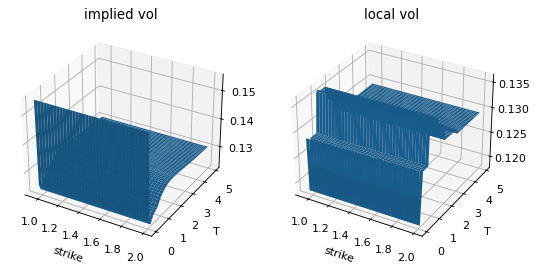

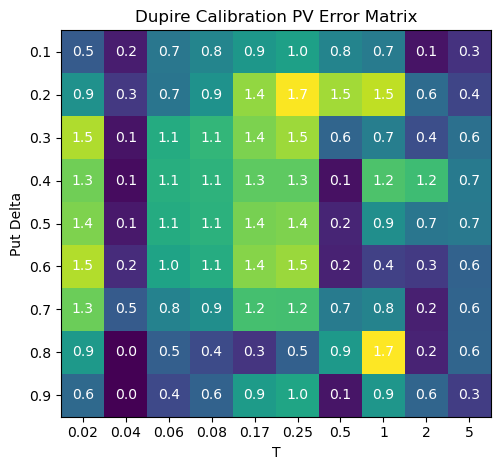

In [15]:
iv = createTestImpliedVol(S, r, q, sc=0, smileInterpMethod='CUBICSPLINE')
plotTestImpliedVolSurface(iv)
pdeCalibReport(S, r, q, iv)

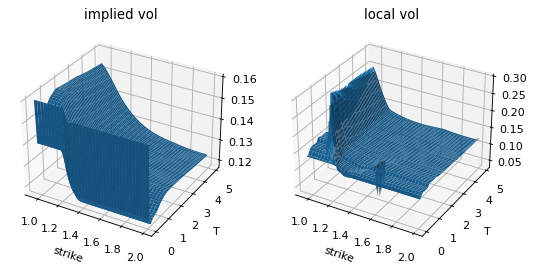

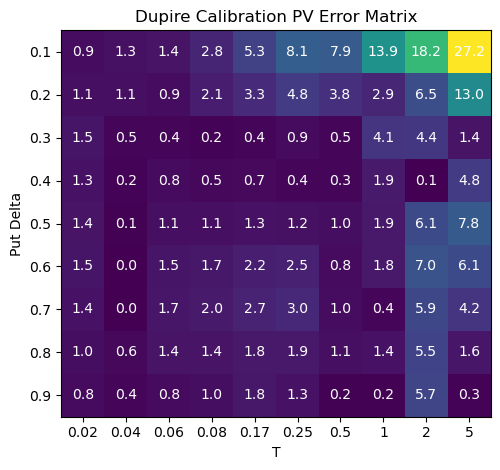

In [16]:
iv = createTestImpliedVol(S, r, q, sc=0.5, smileInterpMethod='CUBICSPLINE')
plotTestImpliedVolSurface(iv)
pdeCalibReport(S, r, q, iv)

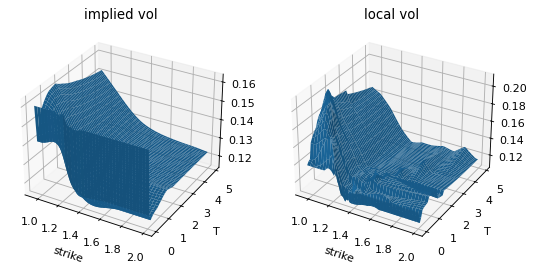

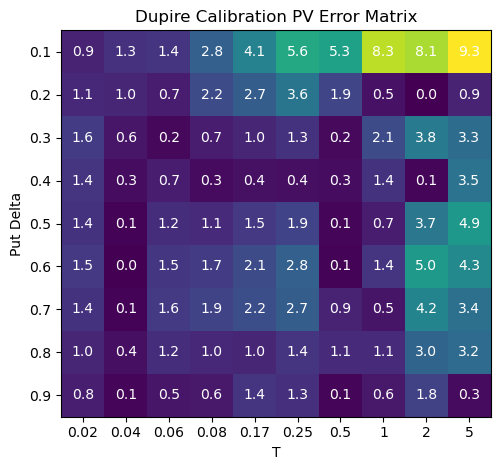

In [25]:
iv = createTestImpliedVol(S, r, q, sc=0.5, smileInterpMethod='AF')
plotTestImpliedVolSurface(iv)
pdeCalibReport(S, r, q, iv)

Then test smile case with CubicSpline, with a the input smile (sc = 1.0). It can be seen that the short end low strike region has some smile arbitrage. The calibration errors become larger.

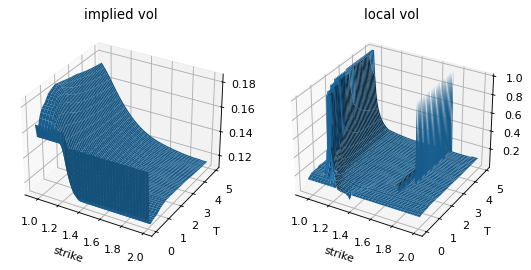

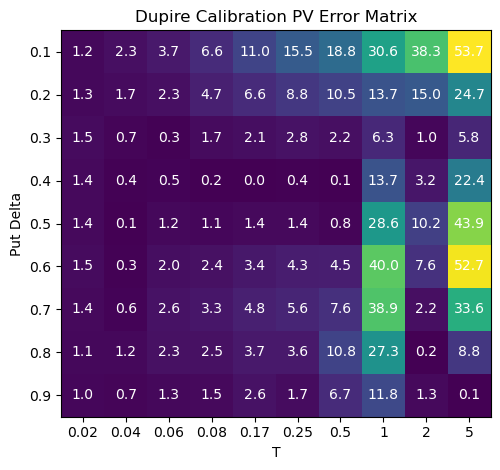

In [17]:
iv = createTestImpliedVol(S, r, q, sc=1.0, smileInterpMethod='CUBICSPLINE')
plotTestImpliedVolSurface(iv)
pdeCalibReport(S, r, q, iv)

Now, test the `SmileAF` implementation to see if there are any improvements over the simple cubic spline `Smile`.

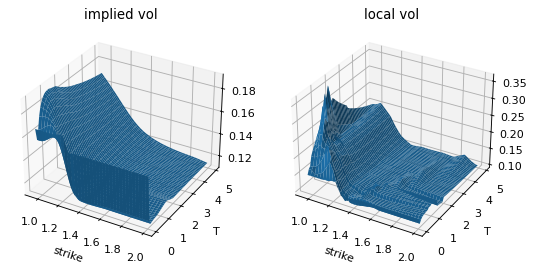

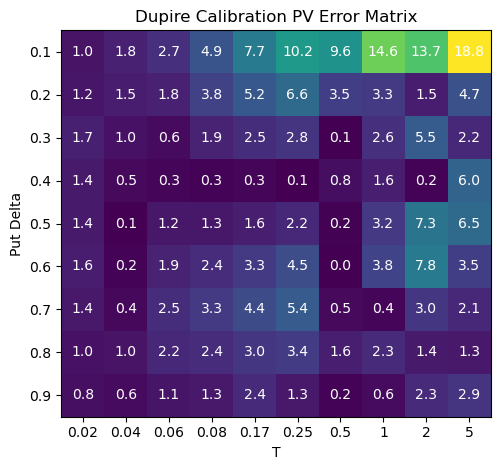

In [18]:
iv = createTestImpliedVol(S, r, q, sc=1.0, smileInterpMethod='AF')
plotTestImpliedVolSurface(iv)
pdeCalibReport(S, r, q, iv)

For `sc = 1`, we see the calibration error at the top right decrease from 53.7 to 18.8. At some cells, there's a slight worsening, but we see improvement in a lot of cells especially with longer expiry. We can see a similar improvement in the `sc = 0.5` case.